# Employee Attrition Predictor

## Project Overview
### Problem Statement
Problem: Employee attrition refers to the reduction in a company workforce due to employee leaving and not being replaced. It can lead to productivity and expense loss as the company has to spend money to recruit, hire and train new employees. 

Objective: In this project, I aim to build a predictive machine learning model that can identify if an employee is likely to leave the company based on features such as satisfaction level, performance evaluation, workload, promotion history and department. By analysing the dataset, this model will help HR departments to identify at-risk employees and intervene with timely engagement or retention efforts.

### Dataset Features
- satisfaction_level: Employee satisfaction rating, ranging from 0 to 1 (e.g., 0.5 for medium satisfaction).
- last_evaluation: Last performance evaluation score, from 0 to 1 (e.g., 0.8 for high performance).
- number_project: Number of projects completed by the employee (e.g., 5 projects).
- average_montly_hours: Average monthly working hours (e.g., 150 hours).
- time_spend_company: Years spent in the company (e.g., 3 years).
- Work_accident: Indicates if the employee had a work accident (1 for yes, 0 for no).
- left: Indicates if the employee left the company (1 for left, 0 for stayed).
- promotion_last_5years: Indicates if the employee was promoted in the last 5 years (1 for yes, 0 for no).
- sales: Department in which the employee works (e.g., sales, technical).
- salary: Salary level of the employee (e.g., low, medium, high).

### <b>1. Import Required Libraries<b/>

In [2]:
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import randint, uniform
from sklearn.metrics import log_loss
from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [3]:
sns.set(style="darkgrid") # Set the style for seaborn plots

### <b>2. Load Dataset<b/>

In [4]:
df0 = pd.read_csv('HR.csv')
df = df0.copy()
# Display the first few rows of the dataframe
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### <b>3. Exploratory Data Analysis (EDA)<b/>

#### 3.1 Basic Information

In [5]:
# Display basic information about the dataset
df.info()

# Display the number of rows and columns in the dataset
print(f"\nNumber of rows: {df.shape[0]}\nNumber of columns: {df.shape[1]}\n")
# Check for missing values in the dataset
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("Missing values found in the following columns:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values found in the dataset.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB

Number of rows: 14999
Number of columns: 10

No missing values found in the dataset.


In [6]:
# Summary statistics for numerical variables
print("Summary statistics for numerical variables:")
print(df.describe())

Summary statistics for numerical variables:
       satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000 

##### Insight: 
- The ranges of values seem reasonable and there is no negative values
- 'work_accident', 'left' and 'promotion_last_5years' are binary values (1 = 'Yes' and 0 = 'No'). Even though it is integer data type but it is categorical variables. They should be converted so that we can do proper data analysis in the later steps

In [7]:
# Change the data type of 'work_accident', 'left' and 'promotion_last_5years' to object
numerical_features = ['satisfaction_level', 'last_evaluation', 'number_project',
                      'average_montly_hours', 'time_spend_company']
features_to_convert = [feature for feature in df.columns if feature not in numerical_features]
df[features_to_convert] = df[features_to_convert].astype('object')
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident             object
left                      object
promotion_last_5years     object
sales                     object
salary                    object
dtype: object

In [8]:
# Summary statistics for categorical variables
print("Summary statistics for categorical variables:")
print(df.describe(include=['object']))

Summary statistics for categorical variables:
        Work_accident   left  promotion_last_5years  sales salary
count           14999  14999                  14999  14999  14999
unique              2      2                      2     10      3
top                 0      0                      0  sales    low
freq            12830  11428                  14680   4140   7316


##### Insight:
- Majority of the employees have not experience any work accident prior to the data collection 
- Majority of the employees stay with the company (11,428 indicate 0). This mean that the dataset is imbalanced and may be bias towards employees who have not left
- 97% of the employees (14,680 out of 14,999) also did not have any promotion in the last few years

##### 3.2 Data Cleaning

Handle inconsistencies, typos and renaming column

In [9]:
# Check for typos and inconsistencies in categorical columns
def check_unique_values(df):
    for column in df.select_dtypes(include=['object']).columns:
        unique_values = df[column].unique()
        print(f"Unique values in '{column}': {unique_values}")  
check_unique_values(df)

Unique values in 'Work_accident': [0 1]
Unique values in 'left': [1 0]
Unique values in 'promotion_last_5years': [0 1]
Unique values in 'sales': ['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']
Unique values in 'salary': ['low' 'medium' 'high']


##### Insight:
- Inconsistent column naming format (some begin with uppercase letter while some follow snake_case)
- 'average_montly_hours' has typo error
- the 'sales' column is supposed to be representing the department of the employees

In [10]:
# Standardize column names to snake_case
df.columns = df.columns.str.lower()

# Correct the typo in 'average_montly_hours' column
df.rename(columns={'average_montly_hours': 'average_monthly_hours'}, inplace=True)

# Change 'sales' column to represent the department of the employees
df.rename(columns={'sales': 'department'}, inplace=True)

# Print the column names to verify changes
print("\nUpdated column names:")
print(pd.Series(df.columns))


Updated column names:
0       satisfaction_level
1          last_evaluation
2           number_project
3    average_monthly_hours
4       time_spend_company
5            work_accident
6                     left
7    promotion_last_5years
8               department
9                   salary
dtype: object


Handling Duplicates

In [11]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")
if duplicate_rows > 0:
    df = df.drop_duplicates()
    print(f"Duplicate rows removed. New number of rows: {df.shape[0]}")

Number of duplicate rows: 3008
Duplicate rows removed. New number of rows: 11991


In [94]:
# save cleaned data to CSV file
df.to_csv('HR_cleaned.csv', index=False)

##### 3.3 Data Visualizations

I want to investigate whether the following:
- 3.3.1 Is it true that higher satisfaction will lead to lower attrition
- 3.3.2 Why did high-satisfaction employees leave?
- 3.3.3 Why do people stay?
- 3.3.4 Which department earn the most and work the least on average?
- 3.3.5 Correlation Matrix between Features

##### 3.3.1 Is it true that higher satisfaction leads to lower attrition

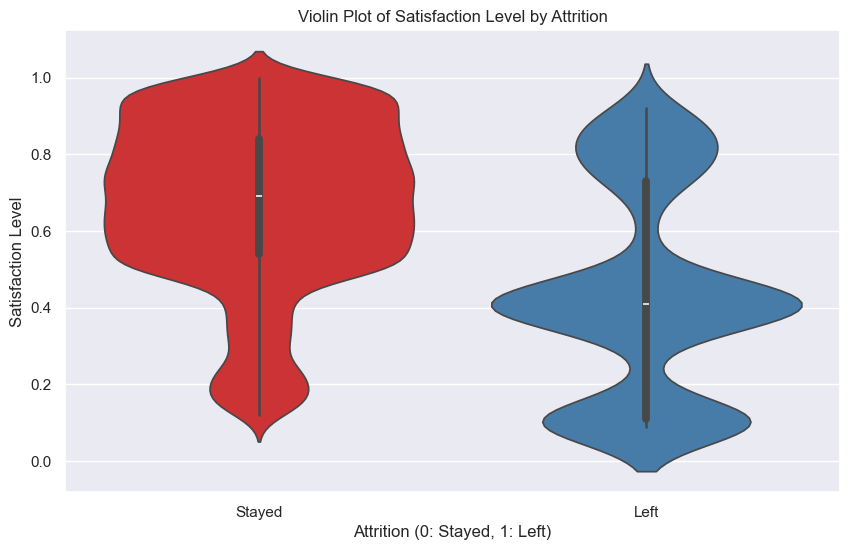

Median satisfaction level by attrition:
left
0    0.69
1    0.41
Name: satisfaction_level, dtype: float64


In [86]:
# plot the distribution of the target variable 'left' against the 'satisfaction_level'
def violinplot_satisfaction_vs_left(df):
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x='left', y='satisfaction_level', palette='Set1')
    plt.title('Violin Plot of Satisfaction Level by Attrition')
    plt.xlabel('Attrition (0: Stayed, 1: Left)')
    plt.ylabel('Satisfaction Level')
    plt.xticks([0, 1], ['Stayed', 'Left'])
    plt.show()

violinplot_satisfaction_vs_left(df)

median_satisfaction = df.groupby('left')['satisfaction_level'].median()
print("Median satisfaction level by attrition:")
print(median_satisfaction)


Violin plot is used to show the density and data spread of the 2 groups left and stay
- Generally, the employees who left the company had a lower satisfaction score than the one who stay. This is seen from the box plot where the median satisfaction for employees who stayed (~0.7) is significantly higher than those who left (~0.4)
- Moreover, the distribution for employees who stay is centered around 0.6 to 0.9. This means that most employees who stayed were moderately to highly satisfied
- Whereas, the distribution for employees who left is concentrated at lower satisfaction levels from 0 to 0.2 and 0.3 to 0.5. However there is also a number of employees who satisfaction is around 0.8 but decide to leave (small bump around satisfaction_level of 0.8)
- In conclusion, this support the hypothesis that higher satisfaction is associated with lower likelihood of attrition

##### 3.3.2 Why did high-satisfaction employees leave?

In [13]:
# find reasons for attrition
def filter_high_sat_left(df):
    # Filter the DataFrame for employees who left the company but high satisfaction
    high_sat_left = df[(df['left'] == 1) & (df['satisfaction_level'] > 0.7)]
    return high_sat_left
filtered_df = filter_high_sat_left(df)

- Employees who left with high satisfaction level (mean = 0.82 and min = 0.71) are also high performers in the company as seen from the mean of last evaluation = 0.91. This mean that the reason they leave the company was not because they were unsatisfied or underperforming.
- And losing these skilled and experienced employees are a huge loss for the company hence it is crucial to know the reasons why they choose to leave

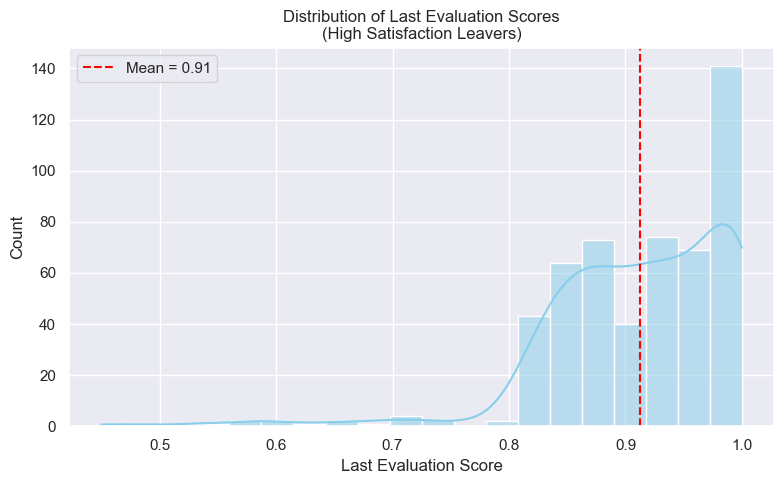

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(filtered_df['last_evaluation'], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Last Evaluation Scores\n(High Satisfaction Leavers)")
plt.xlabel("Last Evaluation Score")
plt.ylabel("Count")
plt.axvline(filtered_df['last_evaluation'].mean(), color='red', linestyle='--', label=f"Mean = {filtered_df['last_evaluation'].mean():.2f}")
plt.legend()
plt.tight_layout()
plt.show()

1. Overworking: This is seen from the high mean average_monthly_hours where the mean working hours is 244 hours per month with the max = 307 hours. This is 44 hours more than the mean of the monthly working hours for the entire company. Even though they are satisfied that doesn't mean they are not burnout.

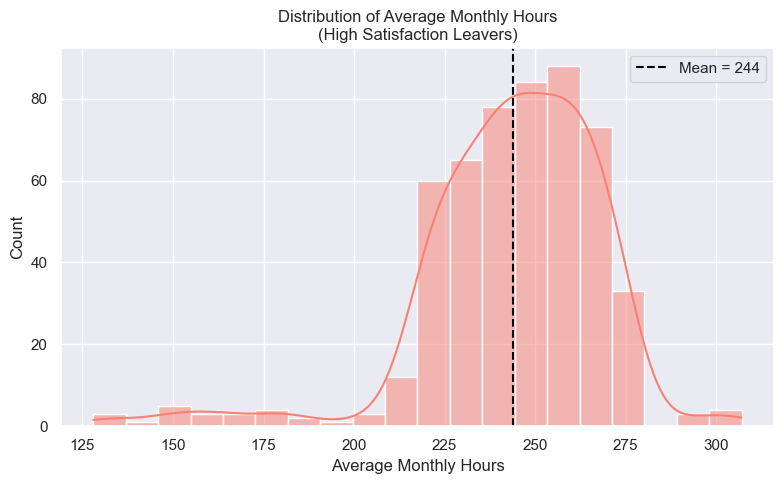

In [15]:
plt.figure(figsize=(8, 5))
sns.histplot(filtered_df['average_monthly_hours'], bins=20, kde=True, color="salmon")
plt.title("Distribution of Average Monthly Hours\n(High Satisfaction Leavers)")
plt.xlabel("Average Monthly Hours")
plt.ylabel("Count")
plt.axvline(filtered_df['average_monthly_hours'].mean(), color='black', linestyle='--', label=f"Mean = {filtered_df['average_monthly_hours'].mean():.0f}")
plt.legend()
plt.tight_layout()
plt.show()

2. No promotion: This is seen from the promotion_last_5years variable where only 2 out of a total of 525 employees(99.6%) who are highly satisfied and well-performed employees got promoted in the last 5 years. They choose to leave because their effort was not recognized by the company for better opportunities

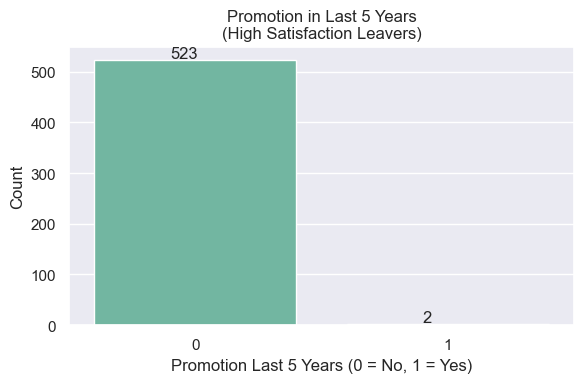

In [16]:
plt.figure(figsize=(6, 4))
sns.countplot(x='promotion_last_5years', data=filtered_df, palette="Set2")
plt.title("Promotion in Last 5 Years\n(High Satisfaction Leavers)")
plt.xlabel("Promotion Last 5 Years (0 = No, 1 = Yes)")
plt.ylabel("Count")
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + 0.3, p.get_height() + 5))
plt.tight_layout()
plt.show()

3. Salary: Almost half of them (305 out of 525 = 58%) stated that they had low salary while only 11 of them have high salaries given their excellence performance

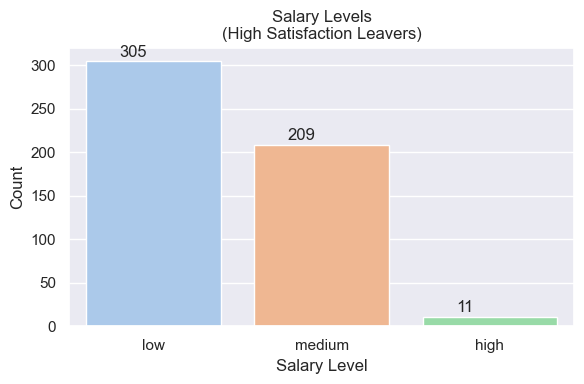

In [17]:
plt.figure(figsize=(6, 4))
sns.countplot(x='salary', data=filtered_df, order=["low", "medium", "high"], palette="pastel")
plt.title("Salary Levels\n(High Satisfaction Leavers)")
plt.xlabel("Salary Level")
plt.ylabel("Count")
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + 0.2, p.get_height() + 5))
plt.tight_layout()
plt.show()

##### 3.3.3 Why do people stay?

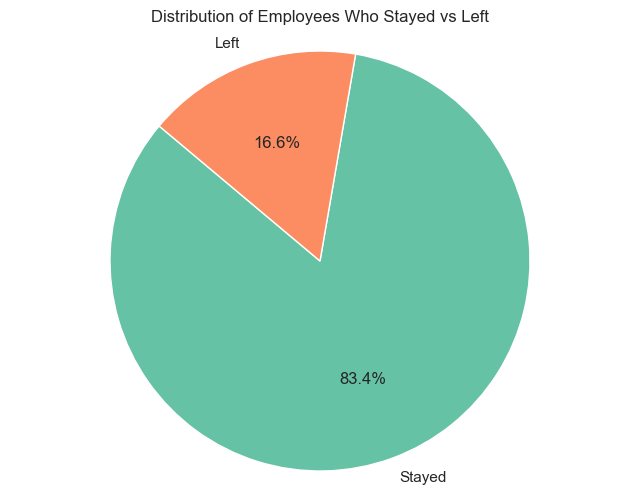

In [18]:
# show pie chart the distribution of the people who stay and left
left_counts = df['left'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(left_counts, labels=['Stayed', 'Left'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
plt.title('Distribution of Employees Who Stayed vs Left')
plt.axis('equal')  
plt.show()

In [19]:
stayed_df = df[df['left'] == 0]

stayed_df.describe(include='all')

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.0,10000.0,10000,10000
unique,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,10,3
top,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,sales,low
freq,NaN,NaN,NaN,NaN,NaN,8255.0,10000.0,9805.0,2689,4566
mean,0.667365,0.715667,3.786800,198.942700,3.262000,NaN,NaN,NaN,NaN,NaN
std,0.217082,0.161919,0.981755,45.665507,1.367239,NaN,NaN,NaN,NaN,NaN
min,0.120000,0.360000,2.000000,96.000000,2.000000,NaN,NaN,NaN,NaN,NaN
25%,0.540000,0.580000,3.000000,162.000000,2.000000,NaN,NaN,NaN,NaN,NaN
50%,0.690000,0.710000,4.000000,198.000000,3.000000,NaN,NaN,NaN,NaN,NaN
75%,0.840000,0.850000,4.000000,238.000000,4.000000,NaN,NaN,NaN,NaN,NaN


- Majority of people who stay have high satisfaction level as seen from the graph where there is a sharp peak between value of 0.6 to 0.9. However, there is also a distinct bump around 0.2 suggesting that there is a small number of employees who are very unsatisfied but still chose to stay
- Most of the employees who stayed are also moderate to high performers as seem from the graph where it centered around 0.6 to 0.9. Though there is also a few who are underperforming in the company

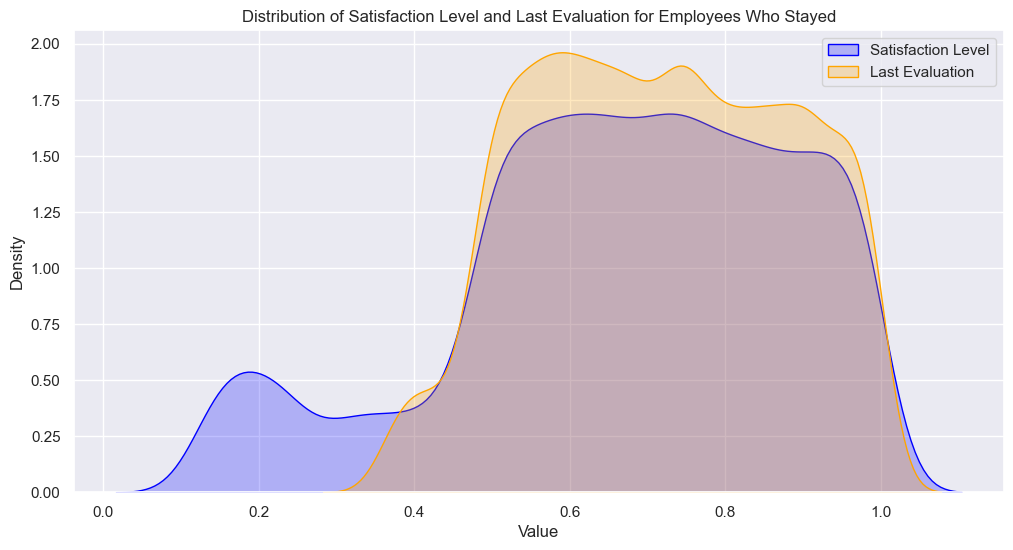

In [20]:
# display the distribution of the 'satisfaction_level' and last_evaluation for employees who stayed
plt.figure(figsize=(12, 6))
sns.kdeplot(stayed_df['satisfaction_level'], color='blue', label='Satisfaction Level', shade=True)
sns.kdeplot(stayed_df['last_evaluation'],  color='orange', label='Last Evaluation', shade=True)
plt.title('Distribution of Satisfaction Level and Last Evaluation for Employees Who Stayed')
plt.xlabel('Value')
plt.legend()
plt.show()

- Around 90% of them indicated that their salaries are low or medium but still decided to stay with the company. This means that salary is not the main driver of retention. In fact other factors such as job security or work culture may play a part
- More over the distribution of average_monthly_hours show that the people who choose to stay work for around 199 hours per month which is around 9 hours a day. This is not extremely high or low. This may be a reason why they choose to stay

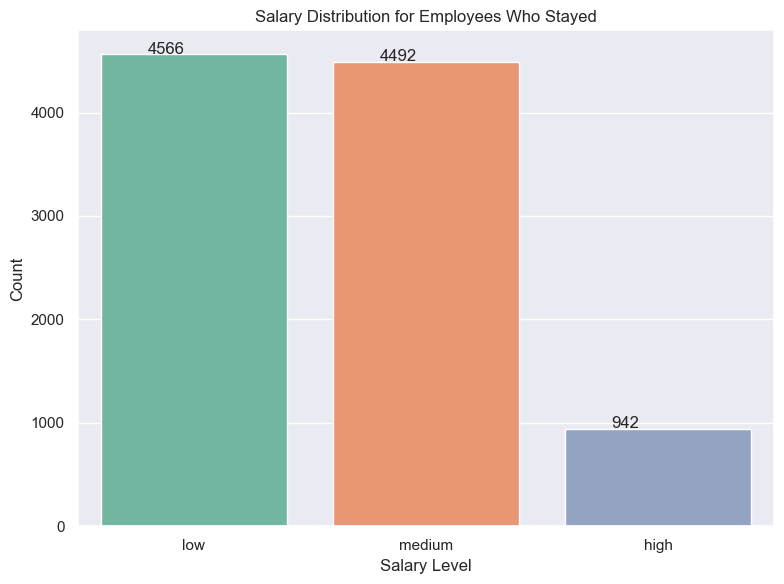

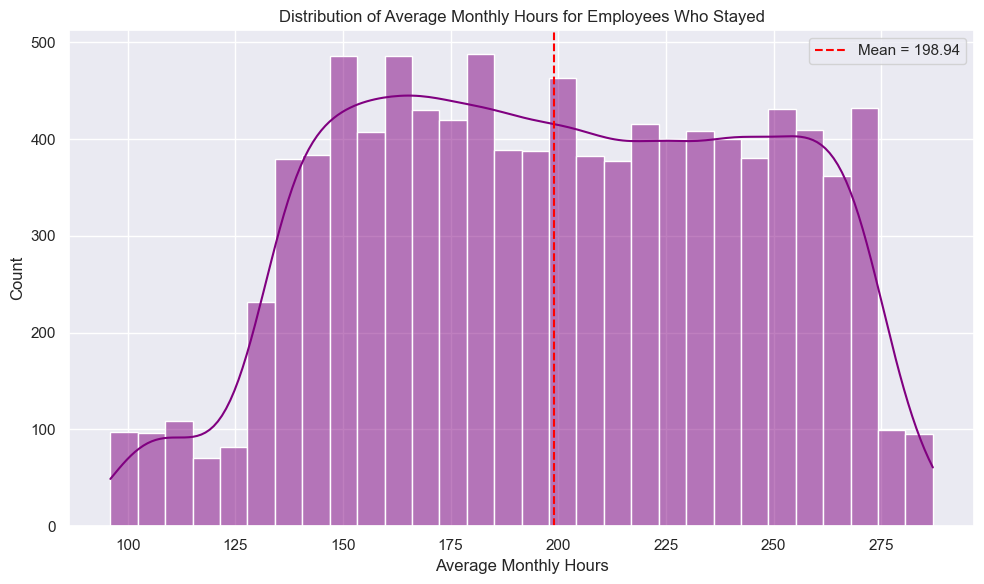

In [21]:
# Salaries distribution for employees who stayed
plt.figure(figsize=(8, 6))
sns.countplot(x='salary', data=stayed_df, order=["low", "medium", "high"], palette="Set2")
plt.title('Salary Distribution for Employees Who Stayed')
plt.xlabel('Salary Level')
plt.ylabel('Count')
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + 0.2, p.get_height() + 5))
plt.tight_layout()
plt.show()

# the hour they worked per month
plt.figure(figsize=(10, 6))
sns.histplot(stayed_df['average_monthly_hours'], bins=30, kde=True, color='purple')
plt.title('Distribution of Average Monthly Hours for Employees Who Stayed')
plt.xlabel('Average Monthly Hours')
plt.ylabel('Count')
plt.axvline(stayed_df['average_monthly_hours'].mean(), color='red', linestyle='--', label=f'Mean = {stayed_df["average_monthly_hours"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
low_sat_stayed = stayed_df[stayed_df['satisfaction_level'] < 0.3]

count_low_sat_stayed = low_sat_stayed.shape[0]
print(f"Number of employees who stayed but have low satisfaction level: {count_low_sat_stayed}")
low_sat_stayed.describe(include='all')

Number of employees who stayed but have low satisfaction level: 831


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
count,831.000000,831.000000,831.000000,831.000000,831.000000,831.0,831.0,831.0,831,831
unique,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,10,3
top,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,sales,low
freq,NaN,NaN,NaN,NaN,NaN,676.0,831.0,818.0,245,383
mean,0.197064,0.708436,4.444043,200.519856,4.413959,NaN,NaN,NaN,NaN,NaN
std,0.045860,0.170389,1.162231,48.533598,1.399483,NaN,NaN,NaN,NaN,NaN
min,0.120000,0.360000,2.000000,96.000000,2.000000,NaN,NaN,NaN,NaN,NaN
25%,0.160000,0.570000,4.000000,163.000000,3.000000,NaN,NaN,NaN,NaN,NaN
50%,0.190000,0.720000,5.000000,201.000000,4.000000,NaN,NaN,NaN,NaN,NaN
75%,0.230000,0.850000,5.000000,239.000000,5.000000,NaN,NaN,NaN,NaN,NaN


Only 1.6% out of 831 employees got promoted in the last 5 years and almost half of them said that their salaries are lpw. This may suggest that they have low bargaining power or lack of opportunities to leave hence they did not leave the company despite of the low satisfaction_level is low.

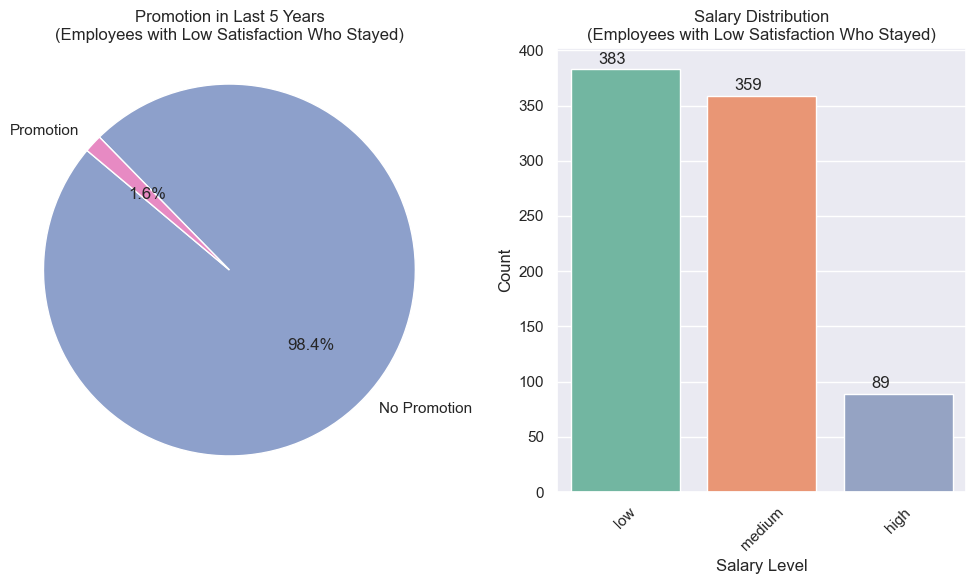

In [23]:
# plot the 2 plot together side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Pie chart for promotion in last 5 years
promotion_counts = low_sat_stayed['promotion_last_5years'].value_counts()
axes[0].pie(promotion_counts, labels=['No Promotion', 'Promotion'], autopct='%1.1f%%', startangle=140, colors=['#8da0cb', '#e78ac3'])
axes[0].set_title('Promotion in Last 5 Years\n(Employees with Low Satisfaction Who Stayed)')
axes[0].axis('equal')
salary_counts = low_sat_stayed['salary'].value_counts()

# Bar chart for salary distribution
sns.barplot(x=salary_counts.index, y=salary_counts.values, palette='Set2', ax=axes[1])
axes[1].set_title('Salary Distribution\n(Employees with Low Satisfaction Who Stayed)')
axes[1].set_xlabel('Salary Level')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(salary_counts.index, rotation=45)
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}', (p.get_x() + 0.2, p.get_height() + 5))

plt.tight_layout()
plt.show()


Most of them have 4 or more years of working at the company. This may be correlated to why they are not switching jobs.

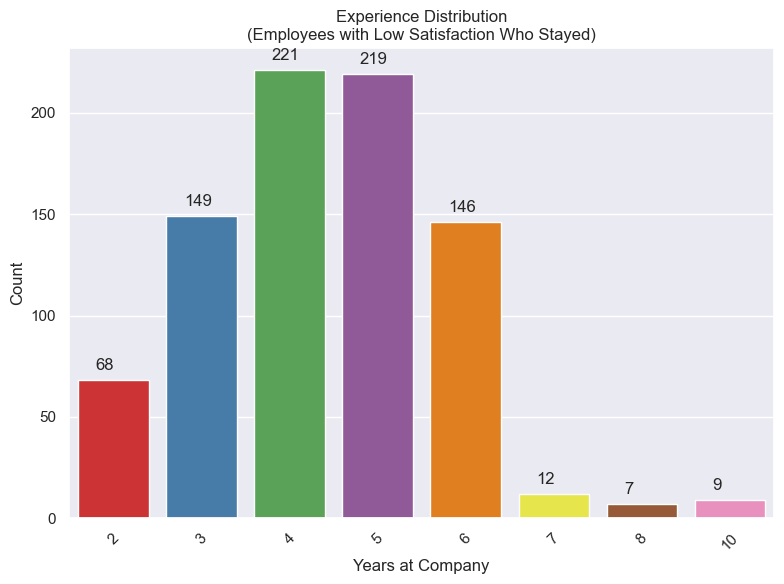

In [24]:
# experience of employees who stayed but have low satisfaction level
plt.figure(figsize=(8, 6))
experience_counts = low_sat_stayed['time_spend_company'].value_counts()
sns.barplot(x=experience_counts.index, y=experience_counts.values, palette='Set1')
plt.title('Experience Distribution\n(Employees with Low Satisfaction Who Stayed)')
plt.xlabel('Years at Company')
plt.ylabel('Count')
plt.xticks(rotation=45)
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + 0.2, p.get_height() + 5))
plt.tight_layout()
plt.show()

##### 3.3.4 Which department earn the most and work the least on average?

- Managment department has the highest salary on average while lowest salary level on average belong to technical and human resources department
- Despite the difference in salaries, the average monthly working hours are similar among the departments

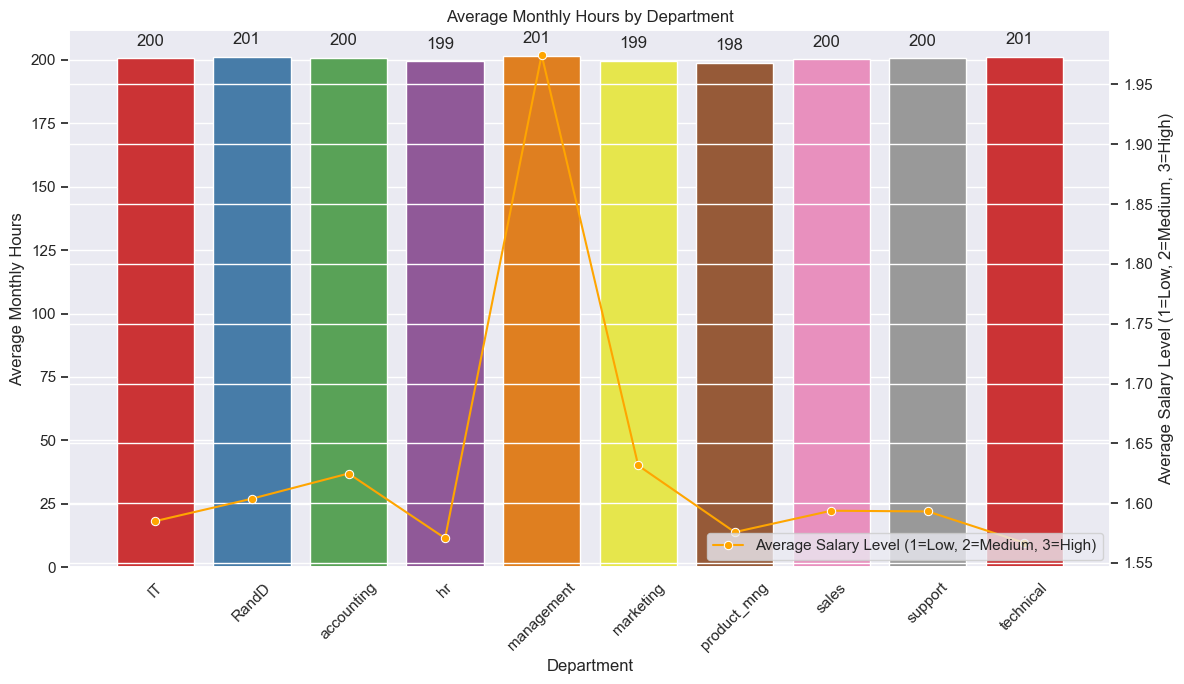

In [25]:
department_stats = df.groupby('department').agg({
    'average_monthly_hours': 'mean',
    'salary': lambda x: x.map({'low': 1, 'medium': 2, 'high': 3}).mean()
}).reset_index()
# Create a bar plot for average monthly hours
plt.figure(figsize=(12, 7))
sns.barplot(x='department', y='average_monthly_hours', data=department_stats, palette='Set1')
plt.title('Average Monthly Hours by Department')
plt.xlabel('Department')
plt.ylabel('Average Monthly Hours')
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + 0.2, p.get_height() + 5))
plt.xticks(rotation=45)
plt.twinx()  # Create a second y-axis
sns.lineplot(x='department', y='salary', data=department_stats, color='orange', marker='o', label='Average Salary Level (1=Low, 2=Medium, 3=High)')
plt.ylabel('Average Salary Level (1=Low, 2=Medium, 3=High)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show() 

3.3.5 Correlation Coefficients between Features

From the correlation matrix, we can see that:
- satisfaction_level has the strongest negative correlation with attrition (left), indicating that higher satisfaction levels are associated with lower attrition rates. It will have more influence on the prediction than the rest of the column because of the high coefficent
- Number of project has a moderate positive correlation with average monthly hours suggesting that the more projects an employee is involved in, the more hours they tend to work on average.
- There is no multicollinear problem among the features
- The target column and numerical features also have weak level of correlation

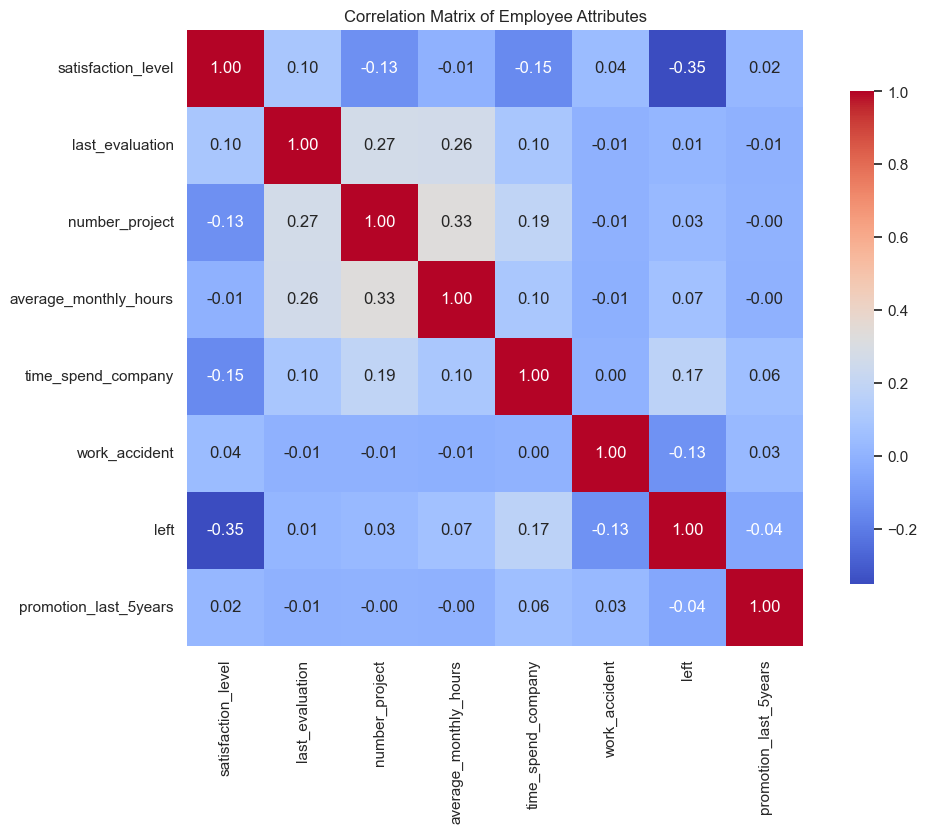

In [26]:
# correlation matrix
plt.figure(figsize=(12, 8))
numerical_columns = ['satisfaction_level', 'last_evaluation', 'number_project',
                     'average_monthly_hours', 'time_spend_company', 'work_accident', 'left', 'promotion_last_5years']
numerical_features = df[numerical_columns]
correlation_matrix = numerical_features.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Employee Attributes')
plt.show()

In [84]:
# create a table to show the correlation coefficients
correlation_coefficients = correlation_matrix['left'].sort_values(ascending=False)
correlation_table = pd.DataFrame(correlation_coefficients).reset_index()
correlation_table.columns = ['Feature', 'Correlation with Attrition']
correlation_table['Correlation with Attrition'] = correlation_table['Correlation with Attrition'].round(2)
correlation_table = correlation_table.sort_values(by='Correlation with Attrition', ascending=False)
print("\nCorrelation Coefficients with Attrition:")
display(correlation_table)


Correlation Coefficients with Attrition:


,Feature,Correlation with Attrition
0,left,1.00
1,time_spend_company,0.17
2,average_monthly_hours,0.07
3,number_project,0.03
4,last_evaluation,0.01
5,promotion_last_5years,-0.04
6,work_accident,-0.13
7,satisfaction_level,-0.35


### <b>4. Data Pre-processing</b>

##### 4.1 Train/Test Split
- Training dataset is used to train the model
- Test dataset is used for the final evaluation

In [83]:
X = df.drop(columns=['left'], axis=1)
y = df['left']
print(y)
y = y.astype('int')  # Ensure y is of type int for classification tasks
print(y)
# Split the dataset into training, testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

0        1
1        1
2        1
3        1
4        1
        ..
11995    0
11996    0
11997    0
11998    0
11999    0
Name: left, Length: 11991, dtype: object
0        1
1        1
2        1
3        1
4        1
        ..
11995    0
11996    0
11997    0
11998    0
11999    0
Name: left, Length: 11991, dtype: int64


##### 4.2 Encoding Categorical Variables
- We will have to encode department and salary since they are categorical data and machine can only understand numerical data. For the other categorical columns (work_accident, left, promotion_last_5years) are already converted into binary data (0 and 1). Hence, I am not going to encode any further
- For department column which is nominal variable, I will be using One hot encoding (OHE) because it is has no inherent order. Using OHE prevent the model from assuming that there is inherent order among the categories.
- For salary which is ordinal variable, I will be using label encoding because it has 3 unique values (low, medium, high) and they have inherent order. Hence, it can be label encoded.

In [29]:
# ohe on department (drop first to avoid multicollinearity)
X_train = pd.get_dummies(X_train, columns=['department'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['department'], drop_first=True)
# label encoding on salary
le = LabelEncoder()
X_train['salary'] = le.fit_transform(X_train['salary'])
X_test['salary'] = le.transform(X_test['salary'])

##### 4.3 Data Scaling
Some machine learning models are sensitive to the scale of the features such as logistic regression which use gradient descent as an optimization techique require data to be scaled. Distance based algorithms such as KNN are also affected by the range of features

In [30]:
numerical_columns = ['satisfaction_level', 'last_evaluation', 'number_project',
                     'average_monthly_hours', 'time_spend_company']

# use the tree-based models on the original data
X_train_tree = X_train.copy()
X_test_tree = X_test.copy()

scaler = MinMaxScaler()
# fit scaler only on training data
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
# transform test data
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

### <b>5. Model Building<b/>

##### 5.1 Baseline Models

In [31]:
lr = LogisticRegression(random_state=42).fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)
rf = RandomForestClassifier(random_state=42).fit(X_train_tree, y_train)
gb = GradientBoostingClassifier(random_state=42).fit(X_train_tree, y_train)
dt = DecisionTreeClassifier(random_state=42).fit(X_train_tree, y_train)

##### 5.2 Cross-Validation on Training Data

- Due to the imbalance in classes of the dataset, accuracy is not a reliable metric as they model can achieve high accuracy by predicting most employees as 0 (stayed)
- In this case precision and recall are a better evaluation metrics as they focus on the performance of the model whereas accuracy measures the overall correctness of the predictions without taking into account the samples of the class.
- Recall is more important than precision for this dataset as we don't want to miss identifying an at-risk employee (wrongly predicted as stay but actually left). It is costlier to lose employees due to turnover costs compare to false alarm. At the same time, we should not totally ignore precision score because too many false alarm can lead to wasting resources and retention efforts. F1 is the average of recall and precison

In [81]:
# evaluate the models
models = {
    'Logistic Regression': lr,
    'KNN': knn,
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'Decision Tree': dt,
}
scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
}
results = []
for name, model in models.items():
    recall = cross_val_score(
        model,
        X_train if "Logistic" in name or "KNN" in name else X_train_tree, 
        y_train, 
        cv=5, 
        scoring=scoring['recall']
    ).mean()
    precision = cross_val_score(
        model,
        X_train if "Logistic" in name or "KNN" in name else X_train_tree,
        y_train,
        cv=5,
        scoring=scoring['precision']
    ).mean()
    f1 = cross_val_score(
        model,
        X_train if "Logistic" in name or "KNN" in name else X_train_tree,
        y_train,
        cv=5,
        scoring=scoring['f1']
    ).mean()
    results.append({
        'Model': name,
        'Recall (Left)': f"{recall:.3f}",
        'Precision (Left)': f"{precision:.3f}", 
        'F1 Score (Left)': f"{f1:.3f}"
    })
results_df = pd.DataFrame(results).sort_values('F1 Score (Left)', ascending=False)

# Print formatted table
print("\nModel Evaluation Results (Cross-Validation Performance):")
display(results_df)


Model Evaluation Results (Cross-Validation Performance):


,Model,Recall (Left),Precision (Left),F1 Score (Left)
2,Random Forest,0.910,0.988,0.948
3,Gradient Boosting,0.926,0.959,0.942
4,Decision Tree,0.910,0.903,0.906
1,KNN,0.847,0.818,0.832
0,Logistic Regression,0.207,0.501,0.293


- Tree-based models outperformed the other models
- Random forest and gradient boosting have almost similar f1 score. 
- Gradient forest has the highest recall (0.926) which mean it misses the fewest at-risk employees whereass random forest has near perfect precision (0.988) meaning it has the lowest false alarms.
- Decision tree perform decently well but slightly worse than random forest and gradient boosting. It is also prone to overfit than random forest and gradient boosting
- KNN perform mediocre which may be due to the imbalanced dataset
- Logistic regression perform terribly for predicting false negatives as evidence from a low recall score (0.207) which means it missing 80% of attritions. It may also be because of the imbalance classes
- I will try to fix logistic regression to see if it can perform better if we add weight to the minority class. Logistic regression is useful when it come to interpretability and it also can give a probabilitistic score. For KNN, the model is not good for scalability in the future as it is not good with large dataset. And the tree-based model is better at predicting than KNN. Hence, I will not be using KNN

In [80]:
lr_balanced = LogisticRegression(random_state=42, class_weight='balanced', C=0.1).fit(X_train, y_train)
metrics = {
    'Recall': cross_val_score(lr_balanced, X_train, y_train, cv=5, scoring='recall'),
    'Precision': cross_val_score(lr_balanced, X_train, y_train, cv=5, scoring='precision'),
    'F1': cross_val_score(lr_balanced, X_train, y_train, cv=5, scoring='f1')
}
results = pd.DataFrame({
    'Metric': ['Recall (Left)', 'Precision (Left)', 'F1 Score (Left)'],
    'Mean Score': [f"{np.mean(metrics['Recall']):.3f}",
                  f"{np.mean(metrics['Precision']):.3f}",
                  f"{np.mean(metrics['F1']):.3f}"],
})
print("Logistic Regression with Class Weighting Results:")
display(results)

Logistic Regression with Class Weighting Results:


,Metric,Mean Score
0,Recall (Left),0.793
1,Precision (Left),0.391
2,F1 Score (Left),0.524


- By using class_weight, it assign higher weights to minority class which is class 1 in this datast. Hence it penalize the model more if there is wrong prediction which force the model to focus more on the minority class and learn its pattern more effectively.
- As a result, logistic regression is now perform significantly better by achieving 79.3% recall (good for catching attritions) improve from 20.7% from the baseline model. However it still has many false alarm

### <b>6. Hyperparameter Tuning<b/>

I will be choosing gradient boosting (highest recall and second highest f1 score) and logistic regression (interpretability) for tuning. Hyperparameter tuning was done without revealing the test data set to avoid data leakage

##### 6.1 Logistic Regression Tuning

I will use Grid search CV for logistic regression because the hyperparameter space is relatively small and interpretable. It only has a few key parameters and hence make it computationally inexpensive which makes it feasible to try all the combinations to find the best settings

In [34]:
# goal to get balance f1 score
param_grid_lr = {
    'penalty': ['l1', 'l2'],  # regularization types (l1 can zero out irrelevant features)
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # controls the strength of regularization (lower C means stronger regularization which can help with overfitting)
    'class_weight': [None, 'balanced'],  # to handle class imbalance
    'solver': ['liblinear', 'saga']
}
grid_search_lr = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid_lr,
    scoring='f1',
    cv=5,
    verbose=1,
)


grid_search_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:")
print(grid_search_lr.best_params_)
print("Best f1 score for Logistic Regression:")
print(grid_search_lr.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for Logistic Regression:
{'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best f1 score for Logistic Regression:
0.5456665969150747


##### 6.2 Gradient Boosting Tuning

However I use Random search CV for gradient boosting because it has a large search space and will save more time compared to grid search CV. Random search CV allow me to explore more configurations in less time but still identifying strong-performing models

In [35]:
# goal to improve recall to catch more attritions
param_grid_gb = {
    'n_estimators': randint(50, 300),  # number of boosting stages to be run
    'learning_rate': uniform(0.01, 0.3),  # step size shrinkage to prevent overfitting
    'max_depth': randint(3, 10),  # maximum depth of the individual trees
    'min_samples_split': randint(2, 20),  # minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 10),  # minimum number of samples required to be at a leaf node
    'subsample': uniform(0.6, 0.4),  # fraction of samples to be used for fitting the individual base learners
}
random_search_gb = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=param_grid_gb,
    n_iter=50,  # number of parameter settings sampled
    scoring='recall',
    cv=5,
    random_state=42,
    verbose=1,  # to see the progress of the search
    n_jobs=-1  # use all available cores
)
random_search_gb.fit(X_train_tree, y_train)


print("Best parameters for Gradient Boosting:")
print(random_search_gb.best_params_)
print("Best recall score for Gradient Boosting:")
print(random_search_gb.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Gradient Boosting:
{'learning_rate': np.float64(0.09545214831324028), 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 179, 'subsample': np.float64(0.7644148053272926)}
Best recall score for Gradient Boosting:
0.9289858435831979


### <b>7. Feature Selection<b/>

##### 7.1 Logistic Regression

Even though I applied L1 regularization with penalty = l1 as one of the params, the number of non-zero coefficient was the same as the total number of features. This mean that L1 regularization did not eliminate any features from the model

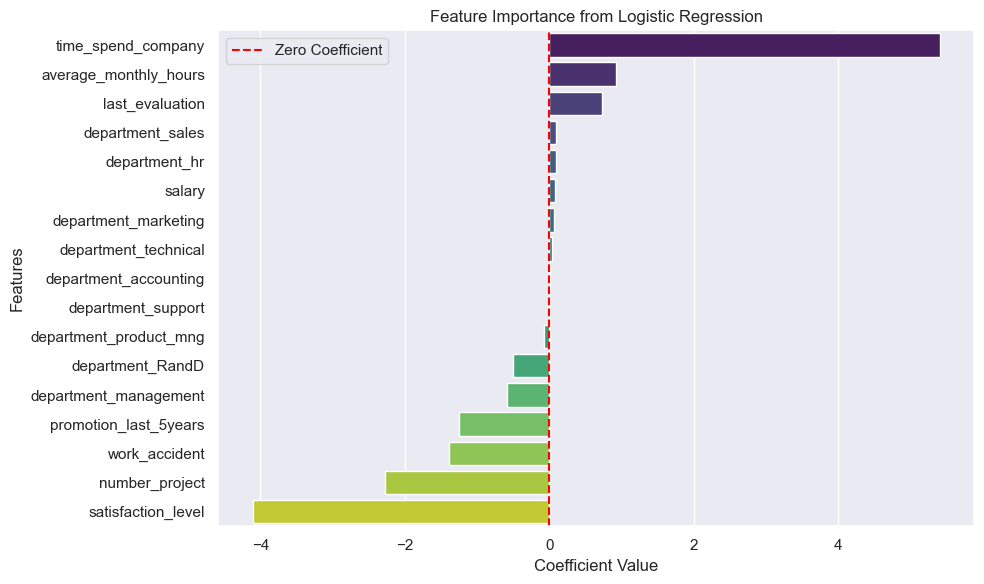

In [37]:
tuned_lr = LogisticRegression(**grid_search_lr.best_params_, random_state=42).fit(X_train, y_train)

coef_mask = tuned_lr.coef_[0] != 0  # Mask for non-zero coefficients
feature_importance_lr = pd.DataFrame({
    'Selected feature': X_train.columns[coef_mask],
    'Importance': tuned_lr.coef_[0][coef_mask]
}).sort_values(by='Importance', ascending=False)
 
#plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Selected feature', data=feature_importance_lr, palette='viridis')
plt.title('Feature Importance from Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.axvline(0, color='red', linestyle='--', label='Zero Coefficient')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
# count the non-zero coefficients
non_zero_coef_count = np.sum(coef_mask)
print(f"\nNumber of non-zero coefficients in Logistic Regression: {non_zero_coef_count}")
# count the x_train features
print(f"\nNumber of features in X_train: {X_train.shape[1]}")


Number of non-zero coefficients in Logistic Regression: 17

Number of features in X_train: 17


Hence, I apply manual feature selection by only keeping features with coeff that has the absolute value of more than 0.1 as I assume that they have more influence to the target given their coefficient. 

In [62]:
# only keep features that have absolute value of coefficients greater than 0.1
selected_features = feature_importance_lr[feature_importance_lr['Importance'].abs() > 0.1]['Selected feature']
X_train_selected = X_train[selected_features]

tuned_lr = LogisticRegression(**grid_search_lr.best_params_, random_state=42).fit(X_train_selected, y_train)

recall_selected = cross_val_score(tuned_lr, X_train_selected, y_train, cv=5, scoring='recall').mean()
recall_not_selected = cross_val_score(tuned_lr, X_train, y_train, cv=5, scoring='recall').mean()
f1_selected = cross_val_score(tuned_lr, X_train_selected, y_train, cv=5, scoring='f1').mean()
f1_not_selected = cross_val_score(tuned_lr, X_train, y_train, cv=5, scoring='f1').mean()

# results in a table format with a column for difference
# Calculate differences
f1_diff = f1_selected - f1_not_selected
recall_diff = recall_selected - recall_not_selected

results_lr_df = pd.DataFrame({
    'Model': [
        'Logistic Regression (Selected Features)', 
        'Logistic Regression (All Features)', 
        'Difference'
    ],
    'Recall': [recall_selected, recall_not_selected, recall_diff],
    'F1 Score': [f1_selected, f1_not_selected, f1_diff]
})

print("\nComparison of Logistic Regression Performance:")
display(results_lr_df)



Comparison of Logistic Regression Performance:


,Model,Recall,F1 Score
0,Logistic Regression (Selected Features),0.829976,0.547943
1,Logistic Regression (All Features),0.828547,0.545667
2,Difference,0.001429,0.002276


Recall and F1 score improve slightly by 0.1% and 0.2% respectively. These are very small improvements however it confirm that by removing near-zero coefficients did not hurt the model performance. At the same time, there is no significant gain also

##### 7.2 Gradient Boosting

I will be performing feature importance on the model to reveal which factors contribute most to predicting employee attrition. First this give interpretability to the management team to take action for example satisfaction level is the top feature, company can focus on this feature to keep the employee. Second, it also help to reduce noise and improve the model performance

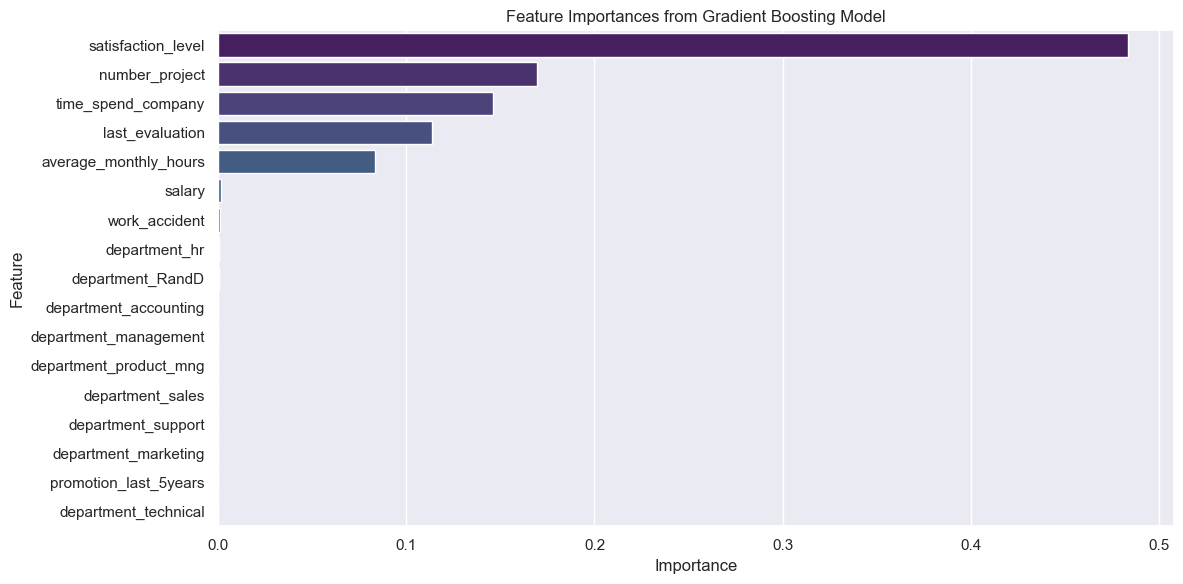

In [40]:
best_gb = GradientBoostingClassifier(**random_search_gb.best_params_, random_state=42).fit(X_train_tree, y_train)

importances = best_gb.feature_importances_
feature_names = X_train_tree.columns

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.title('Feature Importances from Gradient Boosting Model')
plt.tight_layout()
plt.show()



In [67]:
important_features = feature_importances_df[feature_importances_df['Importance'] > 0.01]['Feature']

# filter the DataFrame to keep only important features
X_train_tree_selected = X_train_tree[important_features]

# retraining the best models with the best parameters
best_gb.fit(X_train_tree_selected, y_train)

# compare the performance of the model with and without feature selection
recall_with_fs = cross_val_score(best_gb, X_train_tree_selected, y_train, cv=5, scoring='recall').mean()
recall_without_fs = cross_val_score(best_gb, X_train_tree, y_train, cv=5, scoring='recall').mean()
f1_with_fs = cross_val_score(best_gb, X_train_tree_selected, y_train, cv=5, scoring='f1').mean()
f1_without_fs = cross_val_score(best_gb, X_train_tree, y_train, cv=5, scoring='f1').mean()

# results in a table format with a column for difference
f1_gb_diff = f1_with_fs - f1_without_fs
recall_gb_diff = recall_with_fs - recall_without_fs

results_gb_df = pd.DataFrame({
    'Model': [
        'Logistic Regression (Selected Features)', 
        'Logistic Regression (All Features)', 
        'Difference'
    ],
    'Recall': [recall_with_fs, recall_without_fs, recall_gb_diff],
    'F1 Score': [f1_with_fs, f1_without_fs, f1_gb_diff]
})

print("Comparison of Gradient Boosting Performance:")
display(results_gb_df)


Comparison of Gradient Boosting Performance:


,Model,Recall,F1 Score
0,Logistic Regression (Selected Features),0.923965,0.943629
1,Logistic Regression (All Features),0.928986,0.945616
2,Difference,-0.005020,-0.001988


- Recall and F1 score dropped slightly. The model still maintains a decently strong performance while being simpler
- From the 2 models, the top predictive features are satisfaction_level which is the strongest in both, follow by number_project, time_spend_company, average_monthly_hours and last_evaluation. 
- This is also reflected in my EDA finding where satisfaction level has the highest negative correlation of -0.35. Similarly, time spent at company has the highest positive correlation of 0.17.

### <b>8. Final Evaluation<b/>

- While logistic regression was included due to its interpretable algorithmm, its performance however was significantly lower than that of gradient boosting. Despite applying hyperparameter tuning and feature selection, logistic regression achieved a recall of only 0.83 and an F1 score of 0.548 which is lower than gradient boosting's recall of 0.929 and F1 score of 0.946. 
- Since the objective of this project is to identify as many at-risk employees as possible, gradient boosting was selected as most effective model for deployment and insights
- I will not be using feature importance in my final model because there was no significant performance gain and the model was already performing well. It was more effective to keep all the features in the final model to maximize predictive power and maintain explainability

In [79]:
# train on full set without feature selection
best_gb.fit(X_train_tree, y_train)

# training set performance
y_train_pred_gb = best_gb.predict(X_train_tree)
train_recall = recall_score(y_train, y_train_pred_gb)
train_precision = precision_score(y_train, y_train_pred_gb)
train_f1 = f1_score(y_train, y_train_pred_gb)

# test set performance
y_pred_gb = best_gb.predict(X_test_tree)
test_recall = recall_score(y_test, y_pred_gb)
test_precision = precision_score(y_test, y_pred_gb)
test_f1 = f1_score(y_test, y_pred_gb)

# Calculate the difference between training and testing metrics
recall_diff = test_recall - train_recall
precision_diff = test_precision - train_precision
f1_diff = test_f1 - test_precision

# compile the results into a DataFrame
gb_results = pd.DataFrame({
    'Set': ['Training', 'Testing', 'Difference'],
    'Recall': [train_recall, test_recall, recall_diff],
    'Precision': [train_precision, test_precision, precision_diff],
    'F1 Score': [train_f1, test_f1, f1_diff],
})

# Print the results
print("Gradient Boosting Model Performance:")
display(gb_results)


Gradient Boosting Model Performance:


,Set,Recall,Precision,F1 Score
0,Training,0.932568,0.978179,0.954829
1,Testing,0.931323,0.948805,0.939983
2,Difference,-0.001245,-0.029374,-0.008822


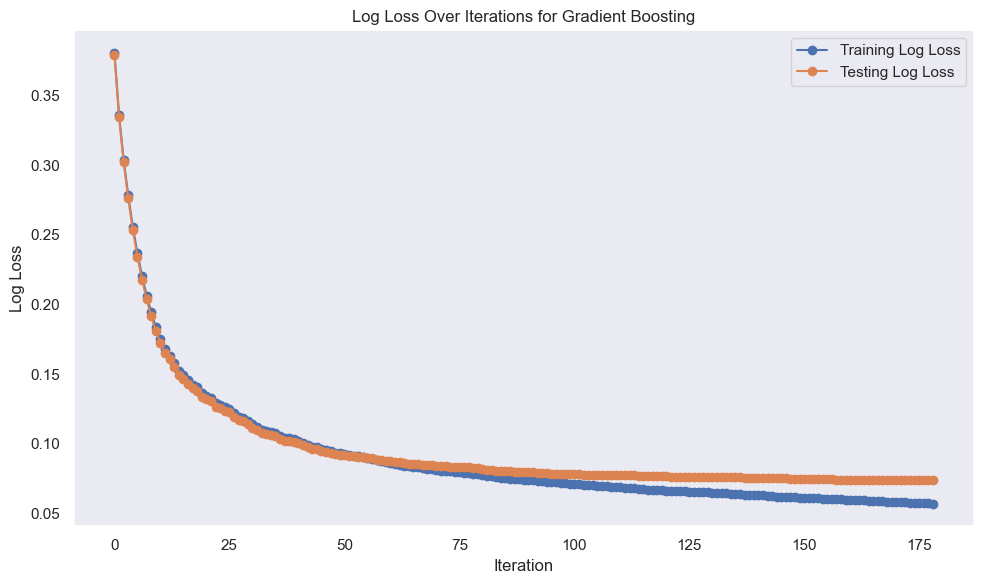

In [43]:
train_log_loss = []
test_log_loss = []
 
for y_train_pred_gb, y_test_pred_gb in zip(
    best_gb.staged_predict_proba(X_train_tree),
    best_gb.staged_predict_proba(X_test_tree)
):
    train_log_loss.append(log_loss(y_train, y_train_pred_gb))
    test_log_loss.append(log_loss(y_test, y_test_pred_gb))
plt.figure(figsize=(10, 6))
plt.plot(train_log_loss, label='Training Log Loss', marker='o')
plt.plot(test_log_loss, label='Testing Log Loss', marker='o')
plt.title('Log Loss Over Iterations for Gradient Boosting')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The model show low variance as seen from the minimal gap between the training and testing performance and by the similar trend in training and testing log loss. Additionally, the high recall and F1 score on both training and testing sets suggest low bias. Thus the model is neither underfitting nor overfitting and achieves a strong balance between bias and variance.

### <b>8. Saving The Trained Model<b/>

In [44]:
import joblib
joblib.dump(best_gb, 'model.pkl')

['model.pkl']

In [45]:
# Save column names used during training
joblib.dump(X_train.columns.tolist(), "columns.pkl")


['columns.pkl']